Nice-to-have extra ablations (fast wins)

- num_workers ∈ {0,2,4,8}: find sweet spot for your CPU.
- Patch size {80,96,112}: check Dice vs. memory/speed.
- Cache dtype float16 vs float32: speed/storage vs. stability.
- Augmentations on/off: quantify impact on Dice & overfitting.

-----------------

Methods—Data Pipeline Ablation.

We compared three preprocessing pipelines for BraTS2020 segmentation with a 3D U-Net: (i) on-the-fly preprocessing (P1), (ii) cached resampled volumes (P2), and (iii) cached patches (P3). All experiments used identical train/val splits, augmentation policies, and hyperparameters; only the data pipeline differed. For P2/P3 we generated cached datasets once prior to training. We measured training throughput (steps/s), epoch wall-time, GPU utilization, and segmentation performance (Dice for whole tumor, tumor core, and enhancing tumor) on the validation set. Each pipeline was run three times with different seeds; we report mean±SD and perform paired statistical tests (t-test) between pipelines.


Data Pipeline Ablation.
We compared three preprocessing pipelines for BraTS2020 segmentation with a 3D U-Net:
(i) on-the-fly preprocessing (P1),
(ii) cached resampled volumes (P2), and
(iii) cached patches (P3).

All experiments used identical training/validation splits, augmentation policies, and hyperparameters; the only difference was the data pipeline. For P2 and P3, cached datasets were generated once prior to training.

We evaluated each pipeline in terms of training throughput (steps/s), epoch wall-time, GPU utilization, and segmentation performance (Dice score for whole tumor, tumor core, and enhancing tumor) on the validation set. Each pipeline was run three times with different random seeds. We report results as mean ± standard deviation and use paired statistical tests (t-test) to assess differences between pipelines.

NOTE: Manually rename segmentation file from patient 355 to "BraTS20_Training_355_seg.nii" from original "W39_1998.09.19_Segm.nii"


METHOD:
Split once using train_test_split.
Use that split to build caches (P2 & P3).
Datasets/loaders for P1, P2, P3 now align perfectly → ✅ fair ablation.


P1: On-the-fly preprocessing

What happens:
Every epoch, raw .nii.gz → load → preprocess → patch extraction → training.

Use case:

Quick prototyping (no disk space used).

If preprocessing is very lightweight.

Good when dataset is small enough and GPU is fast enough.

Drawback:
Slowest throughput (CPU preprocessing every epoch).

🔹 P2: Cached Volumes (preprocessed + resampled)

What happens:

One-time preprocessing of all patients.

Save as .npz files → (4,128,128,128) for images + (128,128,128) for mask.

Training loads directly from .npz each epoch.

Use case:

Middle ground: when you want to avoid repeated expensive preprocessing (resampling, normalization, cropping) but still want flexible patch extraction at training time.

Faster training than P1.

Useful for repeated experiments (same dataset split, different models).

Drawback:

Storage overhead (you duplicate dataset as .npz).

Still need patch extraction on the fly.

🔹 P3: Cached Patches

What happens:

One-time preprocessing and patch extraction.

Save ready-to-train patches as .npz (each file: (4,96,96,96) image + (96,96,96) mask).

Training just shuffles precomputed patches.

Use case:

Maximum training throughput (almost no CPU preprocessing, just file loading).

Useful when you’re running many experiments with the same patch sampling policy.

Works well when GPU is fast and CPU is bottleneck.

Drawback:

Less flexibility (can’t change patch size, augmentation policy, or sampling later without rebuilding cache).

Larger disk usage (because you store many patches per patient).

🔹 Summary (when to use which)

P1 (on-the-fly):
Early experiments, debugging, when storage is limited.

P2 (cached volumes):
Balanced choice → avoids CPU preprocessing overhead, but keeps patching flexible.

P3 (cached patches):
High-performance training, especially when re-running experiments with the same setup (hyperparameters, patch size).
👉 For your report, this ablation is perfect:

Show training throughput difference (steps/sec, epoch wall-time).
Show that segmentation Dice scores are similar, proving that preprocessing choice mainly affects efficiency, not accuracy.


For a fair ablation, patients ids are extracted after splitting data into train/val data and used for caching (P2 and P3) to ensure a more consistent split.
To ensure that they really do match after caching, a sanity check visualization is done. 

A sanity check visualization will confirm that:

P1 (on-the-fly) preprocessing → patch
P2 (cached volumes → patch) → patch
P3 (cached pre-extracted patches) → patch

That all produce the same anatomy + segmentation!

In [1]:
# ##UPDATE REQUIREMENTS

# import pkg_resources

# packages = ["torch", "torchvision", "torchaudio", "numpy", 
#             "nibabel", "nilearn", "scikit-image", "Pillow", 
#             "matplotlib", "scipy", "tqdm"]

# with open("requirements.txt", "w") as f:
#     for p in packages:
#         try:
#             version = pkg_resources.get_distribution(p).version
#             f.write(f"{p}=={version}\n")'
#         except pkg_resources.DistributionNotFound:
#             print(f"⚠️ {p} not installed")

In [1]:
# image = nib.load(filepath).get_fdata() #Load image data
# image = (image - np.min(image1))/np.max(image) - np.min(image1)
# img = Image.fromarray((image[:,:,50] * 225).astype(np.uint8))
# img
# hist_data, bin_edges = np.histogram(img, bins = 256, range=(0,225))
# hist_data.shape
# plt.imshow(img)
# plt.plot(bin_edges[0:-1], hist_data)
# plt.ylim(0, 700)

# plt.hist(image.flatten(), bins = 256)
# plt.ylim(0, 2*10**4.4)

In [12]:
import torch 
import torch.nn as nn
import numpy as np
import nibabel as nib
import os
import PIL.Image as Image
import matplotlib.pyplot as plt

import skimage as ski

PRE PROCESSING ABLATION STUDIES

In [15]:
#Getting helper scripts
from utils.ablation_loader import BraTSDatasetP1
from utils.ablation_loader import BraTSDatasetP2
from utils.ablation_loader import BraTSDatasetP3
from utils.ablation_loader import get_brats_filepaths
from utils.ablation_loader import build_cache
# from utils.ablation_loader import visualize_sample
from utils.ablation_loader import visualize_patient_consistency
from utils.ablation_loader import split_brats_dataset
from utils.metrics import compare_pipelines_dice

In [17]:
RAW_DATA_PATH = "data/raw/"

trainingData_root_dir = os.path.join(
    RAW_DATA_PATH, 
    "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
)

image_paths, mask_paths = get_brats_filepaths(trainingData_root_dir) ##Collecting image and mask file paths for our data loader 
mask_paths[354]

'data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\\BraTS20_Training_355\\BraTS20_Training_355_seg.nii'

In [19]:
#  Performing Patientwise split 
train_imgs, val_imgs, train_masks, val_masks = split_brats_dataset(
    image_paths, mask_paths, val_size=0.2, seed=42
)

print(f"Train patients: {len(train_imgs)}")
print(f"Val patients: {len(val_imgs)}")

# Derive patient IDs from the split lists
def pid_from_modalities(modality_paths):
    """
    modality_paths: list of 4 paths [flair, t1, t1ce, t2]
    Returns the patient folder name used in cache (e.g., 'BraTS20_Training_001').
    """
    return os.path.basename(os.path.dirname(modality_paths[0]))

train_pids = [pid_from_modalities(m) for m in train_imgs]
val_pids   = [pid_from_modalities(m) for m in val_imgs]

# Checking if lengths match
len(train_pids) == len(train_imgs), len(val_pids)   == len(val_imgs)

Train patients: 295
Val patients: 74


(True, True)

In [21]:
##Cache for P2 and P3 using the split
# Cache directories
cache_root = "data/processed/cache"
cache_train = os.path.join(cache_root, "train")
cache_val   = os.path.join(cache_root, "val")

In [23]:


# # Build cache for train and val separately
# build_cache(train_imgs, train_masks, out_dir=cache_train, num_patches=8)  # P2 & P3 train
# build_cache(val_imgs, val_masks, out_dir=cache_val, num_patches=8)        # P2 & P3 val


In [25]:
## Creating datasets for each pipeline; P1, P2, P3

# P1 (on the fly)
train_dataset_P1 = BraTSDatasetP1(train_imgs, train_masks, augment=True)
val_dataset_P1   = BraTSDatasetP1(val_imgs,   val_masks,   augment=False)

# P2 (cached volumes)
train_dataset_P2 = BraTSDatasetP2(
    cache_dir=os.path.join(cache_train, "volumes"),
    patient_ids=train_pids,
    patch_size=(96,96,96),
    augment=True
)
val_dataset_P2 = BraTSDatasetP2(
    cache_dir=os.path.join(cache_val, "volumes"),
    patient_ids=val_pids,
    patch_size=(96,96,96),
    augment=False
)

# P3 (cached patches)
train_dataset_P3 = BraTSDatasetP3(
    cache_dir=os.path.join(cache_train, "patches"),
    patient_ids=train_pids,
    augment=True
)
val_dataset_P3 = BraTSDatasetP3(
    cache_dir=os.path.join(cache_val, "patches"),
    patient_ids=val_pids,
    augment=False
)

Plot saved to results/images/patient-9_rand_consistency.png


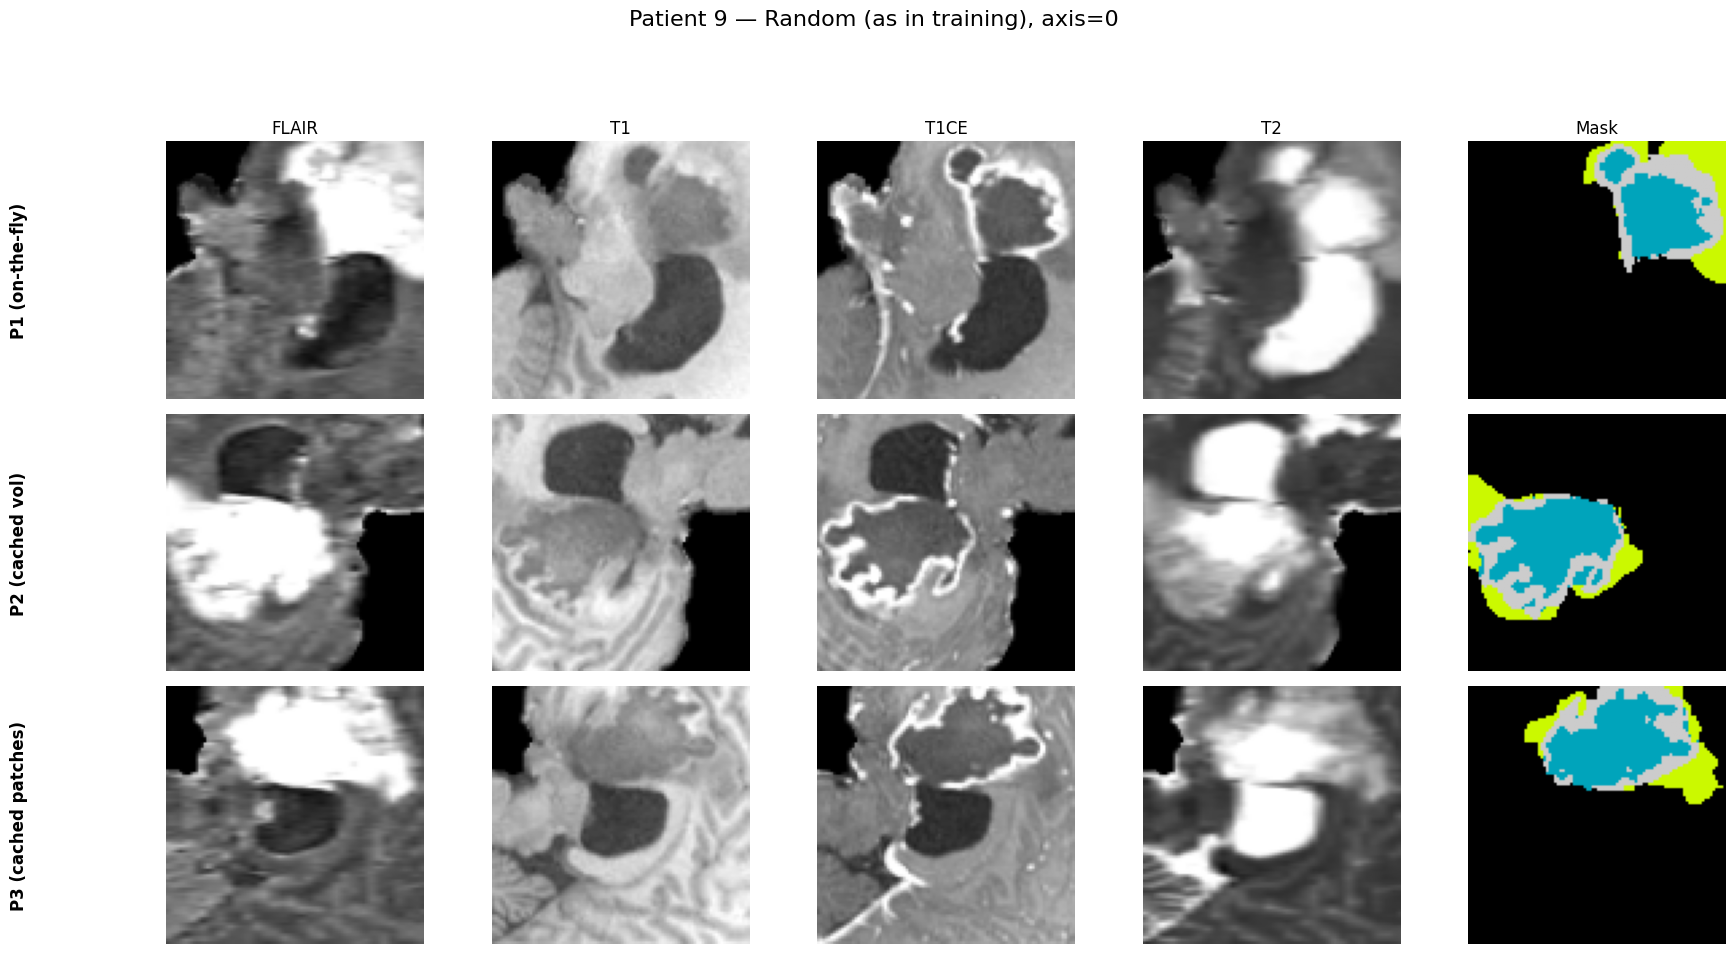

Plot saved to results/images/patient-9_det_consistency.png


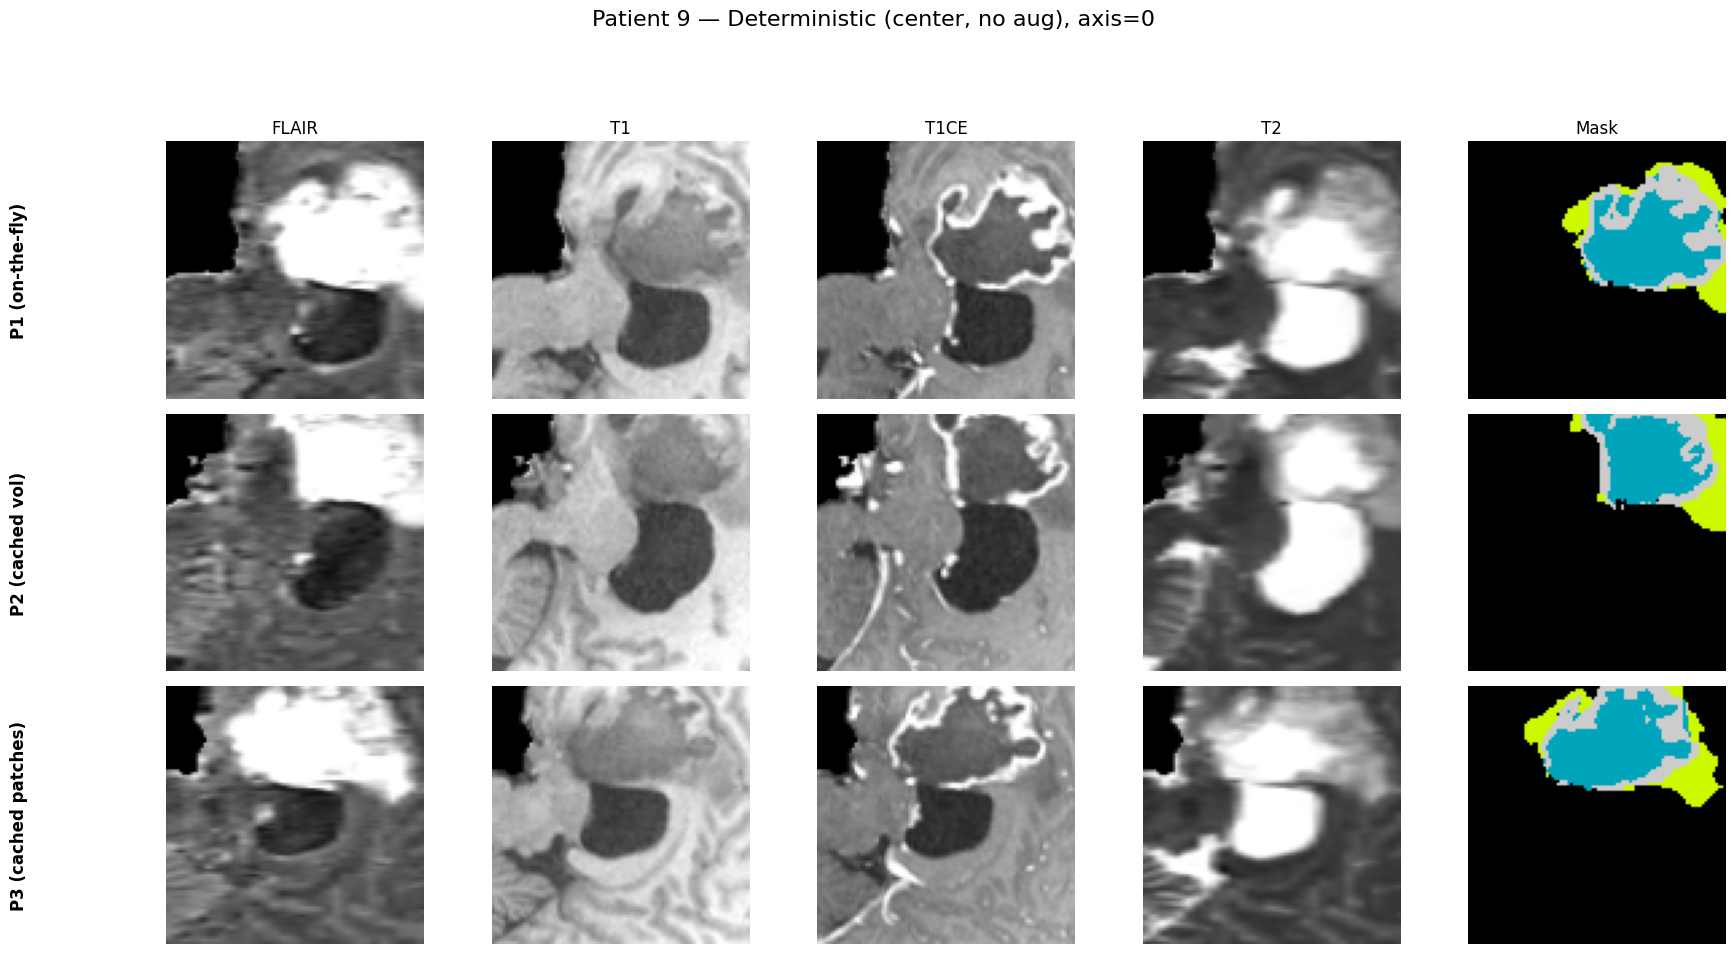

In [51]:


#Visualizing patches produced by the 3 pipelines 
visualize_patient_consistency(train_dataset_P1, train_dataset_P2, train_dataset_P3, patient_idx=9, slice_axis=0, deterministic=False)
visualize_patient_consistency(train_dataset_P1, train_dataset_P2, train_dataset_P3, patient_idx=9, slice_axis=0, deterministic=True)


In [53]:
# dice scores 
results = compare_pipelines_dice(train_dataset_P1, train_dataset_P2, train_dataset_P3, num_samples=20)

regions = ["Whole Tumor", "Tumor Core", "Enhancing Tumor", "All Classes"]

# Print P2 vs P1
print("Dice Scores (P2 vs P1):")
for i, region in enumerate(regions):
    mean = results["P2_vs_P1"][0][i]
    std = results["P2_vs_P1"][1][i]
    print(f"  {region:<15}: {mean:.3f} ± {std:.3f}")

# Print P3 vs P1
print("\nDice Scores (P3 vs P1):")
for i, region in enumerate(regions):
    mean = results["P3_vs_P1"][0][i]
    std = results["P3_vs_P1"][1][i]
    print(f"  {region:<15}: {mean:.3f} ± {std:.3f}")



Dice Scores (P2 vs P1):
  Whole Tumor    : 0.828 ± 0.063
  Tumor Core     : 0.201 ± 0.173
  Enhancing Tumor: 0.308 ± 0.148
  All Classes    : 0.330 ± 0.307

Dice Scores (P3 vs P1):
  Whole Tumor    : 0.789 ± 0.074
  Tumor Core     : 0.144 ± 0.192
  Enhancing Tumor: 0.214 ± 0.131
  All Classes    : 0.261 ± 0.333


In [39]:
from torch.utils.data import DataLoader

#  DataLoaders
batch_size = 2
train_loader_P1 = DataLoader(train_dataset_P1, batch_size=batch_size, shuffle=True)
val_loader_P1   = DataLoader(val_dataset_P1,   batch_size=batch_size, shuffle=False)

train_loader_P2 = DataLoader(train_dataset_P2, batch_size=batch_size, shuffle=True)
val_loader_P2   = DataLoader(val_dataset_P2,   batch_size=batch_size, shuffle=False)

train_loader_P3 = DataLoader(train_dataset_P3, batch_size=batch_size, shuffle=True)
val_loader_P3   = DataLoader(val_dataset_P3,   batch_size=batch_size, shuffle=False)


def train_loader_printout(train_loader):
    for img, mask in train_loader:
        print("Image shape:", img.shape)   # (B,4,96,96,96)  four MRI modalities
        print("Mask shape:", mask.shape)   # (B,4,96,96,96)  one-hot segmentation
        break


# Fetch a batch
train_loader_printout(train_loader_P1), train_loader_printout(train_loader_P2), train_loader_printout(train_loader_P3)

Image shape: torch.Size([2, 4, 96, 96, 96])
Mask shape: torch.Size([2, 4, 96, 96, 96])
Image shape: torch.Size([2, 4, 96, 96, 96])
Mask shape: torch.Size([2, 4, 96, 96, 96])
Image shape: torch.Size([2, 4, 96, 96, 96])
Mask shape: torch.Size([2, 4, 96, 96, 96])


(None, None, None)